In [18]:
import pandas as pd
from utils import average_countries_to_continents
import sys, os
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from Environment.read_co2 import read_co2_continent
# from visualizations.world_map import create_world_bubble_map


data_list_health = ['./data/health/cleaned_data/cleaned_Life expectancy at birth.csv',
                './data/health/cleaned_data/cleaned_Mortality rate, infant (per 1,000 live births).csv']
data_list_economy = ['./data/economy/cleaned_data/cleaned_GDP.csv',
                 './data/economy/cleaned_data/cleaned_Unemployment, total (% of labour force).csv']

min_year = 1991
max_year = 2016
health_data = []
for data in data_list_health:
    #cluster to continents
    health_df = pd.read_csv(data, index_col=0)
    avg_health_df_new = average_countries_to_continents(health_df)
    columns_to_drop = []
    for column in avg_health_df_new.columns:
        if int(column) < min_year or int(column) > max_year:
            columns_to_drop.append(column)
    avg_health_df = avg_health_df_new.drop(columns=columns_to_drop)
    health_data.append(avg_health_df)
health_data[0] = - (health_data[0] - health_data[0].mean()) / health_data[0].std() # inversely normalize when the higher the better
health_data[1] = ( health_data[1] -  health_data[1].mean()) /  health_data[1].std()

avg_health_df = pd.concat([health_data[0], health_data[1]], axis=1).groupby(axis=1, level=0).mean()


econ_data = []
for data in data_list_economy:
    economy_df = pd.read_csv(data, index_col=0)
    avg_economy_df_new = average_countries_to_continents(economy_df)
    columns_to_drop = []
    for column in avg_economy_df_new.columns:
        if int(column) < min_year or int(column) > max_year:
            columns_to_drop.append(column)

    avg_economy_df_new = (avg_economy_df_new - avg_economy_df_new.mean()) / avg_economy_df_new.std()
    avg_economy_df = avg_economy_df_new.drop(columns=columns_to_drop)
    econ_data.append(avg_economy_df)
print(econ_data)

econ_data[0] =  - (econ_data[0] - econ_data[0].mean()) / econ_data[0].std()  # inversely normalize when the higher the better
econ_data[1] = (econ_data[1] - econ_data[1].mean()) / econ_data[1].std()
avg_economy_df = pd.concat([econ_data[0], econ_data[1]], axis=1).groupby(axis=1, level=0).mean()

environment_data = []
for column in ['co2', 'methane']:
    environment_co2 = read_co2_continent(year_start=1990, year_end=2016, usecols=['country', 'year','co2','methane'])
    data_grouped_by_entity = environment_co2.groupby('area')
    co2_groups = [data_grouped_by_entity.get_group(x) for x in data_grouped_by_entity.groups]
    co2_group = co2_groups[0]
    cleaned_co2_df = co2_group[['year', column]]
    cleaned_co2_df = cleaned_co2_df.set_index('year')
    cleaned_co2_df.columns = [co2_group['area'].iloc[0]]

    for i in range(1,len(co2_groups)):
        co2_group = co2_groups[i]
        co2_column = co2_group[['year', 'co2']]
        co2_column = co2_column.set_index('year')
        co2_column.columns = [co2_group['area'].iloc[0]]
        cleaned_co2_df = cleaned_co2_df.join(co2_column)
    cleaned_co2_df = cleaned_co2_df.T[:-1]
    cleaned_co2_df.columns = cleaned_co2_df.columns.map(str)
    cleaned_co2_df = (cleaned_co2_df - cleaned_co2_df.mean()) / cleaned_co2_df.std()
    environment_data.append(cleaned_co2_df)

avg_env_df = pd.concat([environment_data[0], environment_data[1]], axis=1).groupby(axis=1, level=0).mean()
common_cols =  avg_health_df.columns & avg_economy_df.columns & avg_env_df.columns
avg_env_df = avg_env_df[common_cols]
avg_health_df = avg_health_df[common_cols]
avg_economy_df = avg_economy_df[common_cols]

# create_world_bubble_map(avg_health_df, avg_env_df, avg_economy_df, 'world_overall.png')



[                   1991      1992      1993      1994      1995      1996  \
Continent                                                                   
Africa        -1.048695 -1.029803 -1.057465 -1.104652 -1.074925 -1.119375   
Asia           1.147441  1.122191  1.329904  1.304790  1.238101  1.116525   
Europe         1.304667  1.331474  1.091780  1.032289  1.064623  1.121417   
North America -0.506628 -0.512347 -0.490610 -0.548392 -0.668208 -0.667131   
Oceania       -0.782066 -0.794462 -0.823355 -0.830363 -0.816054 -0.815562   
South America -0.114720 -0.117052 -0.050254  0.146328  0.256463  0.364127   

                   1997      1998      1999      2000  ...      2007  \
Continent                                              ...             
Africa        -1.171149 -1.164672 -1.151037 -1.170072  ... -1.211399   
Asia           1.097171  0.910878  1.143229  1.313088  ...  0.893705   
Europe         1.026047  1.181367  1.179420  0.951590  ...  1.347523   
North America -0.62160

In [19]:
avg_health_df

,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Continent,,,,,,,,,,,,,,,,,,,,,
Africa,1.847689,1.858137,1.867433,1.875621,1.883343,1.888826,1.894239,1.899709,1.904416,1.909366,...,1.906058,1.900630,1.894215,1.886078,1.880765,1.873659,1.867561,1.861407,1.856436,1.852238
Asia,0.172953,0.162754,0.153134,0.143763,0.134699,0.122664,0.110847,0.096539,0.082722,0.067664,...,-0.031452,-0.044006,-0.057818,-0.071256,-0.074078,-0.083186,-0.090840,-0.098925,-0.104719,-0.110772
Europe,-1.066726,-1.045524,-1.026191,-1.008528,-0.992896,-0.985117,-0.978067,-0.971417,-0.965588,-0.960422,...,-1.007953,-1.023426,-1.040601,-1.059755,-1.066313,-1.081263,-1.094708,-1.107450,-1.116024,-1.124509
North America,-0.486422,-0.490259,-0.493708,-0.495679,-0.495532,-0.492515,-0.488636,-0.483334,-0.479776,-0.473484,...,-0.403446,-0.387280,-0.368909,-0.348995,-0.367298,-0.354002,-0.341501,-0.329953,-0.319207,-0.310639
Oceania,-0.143362,-0.149369,-0.154575,-0.157731,-0.162208,-0.158887,-0.156823,-0.153387,-0.148355,-0.144586,...,-0.041881,-0.020636,0.001510,0.025842,0.052026,0.070972,0.084563,0.098349,0.110045,0.118596
South America,-0.324132,-0.335739,-0.346094,-0.357446,-0.367406,-0.374971,-0.381558,-0.388110,-0.393419,-0.398538,...,-0.421326,-0.425282,-0.428398,-0.431914,-0.425102,-0.426179,-0.425075,-0.423428,-0.426531,-0.424914


In [20]:
avg_env_df

year,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Africa,-0.853110,-0.865757,-0.860924,-0.857377,-0.848326,-0.848862,-0.844667,-0.849393,-0.849522,-0.833358,...,-0.739773,-0.718212,-0.684299,-0.681603,-0.658460,-0.646266,-0.644179,-0.627512,-0.626192,-0.617416
Asia,0.793311,0.929947,1.009031,1.087270,1.132169,1.157907,1.180632,1.140430,1.172875,1.209326,...,1.573897,1.627852,1.691085,1.705157,1.741054,1.763536,1.764783,1.774969,1.781478,1.788543
Europe,1.097609,0.904867,0.805422,0.691246,0.651265,0.609931,0.551088,0.561826,0.513995,0.464298,...,0.192275,0.149100,0.071029,0.057464,0.012694,-0.009625,-0.035246,-0.071712,-0.069852,-0.071769
North America,0.527628,0.611454,0.628888,0.652758,0.635474,0.642802,0.668804,0.710019,0.712073,0.708566,...,0.363017,0.287825,0.209182,0.185402,0.128538,0.082494,0.100482,0.099241,0.078322,0.057799
Oceania,-1.034511,-1.047126,-1.050986,-1.047332,-1.045415,-1.042781,-1.042808,-1.054314,-1.047195,-1.036988,...,-0.923022,-0.900258,-0.859188,-0.852388,-0.822339,-0.804971,-0.805608,-0.797565,-0.788432,-0.779127
South America,-0.957483,-0.966263,-0.961892,-0.955253,-0.949331,-0.943428,-0.935383,-0.933264,-0.926987,-0.928523,...,-0.836280,-0.805412,-0.769958,-0.754834,-0.730717,-0.708301,-0.702322,-0.691178,-0.688420,-0.686739


In [21]:
avg_economy_df

,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Continent,,,,,,,,,,,,,,,,,,,,,
Africa,1.034640,1.009112,1.000508,0.997657,0.954532,0.974225,0.994396,0.982269,0.963615,0.958766,...,0.985824,0.939651,0.902104,0.896115,0.895086,0.831003,0.821658,0.833556,0.886021,0.940253
Asia,-1.242248,-1.212966,-1.291501,-1.247913,-1.180659,-1.110715,-1.087521,-0.976645,-1.071312,-1.131631,...,-0.891618,-0.923073,-0.961241,-1.012569,-1.044337,-1.135507,-1.053076,-1.058840,-1.120060,-1.179353
Europe,-0.605130,-0.497162,-0.266038,-0.138125,-0.070134,-0.117629,-0.092779,-0.196622,-0.224558,-0.141493,...,-0.140004,-0.055359,0.031310,0.219248,0.277597,0.417431,0.383459,0.326350,0.278114,0.170026
North America,0.629269,0.588051,0.530917,0.513931,0.530254,0.476753,0.398869,0.324198,0.227034,0.133457,...,0.417885,0.471678,0.527148,0.559886,0.616173,0.581396,0.590145,0.594730,0.574512,0.566826
Oceania,-0.168049,-0.212062,-0.235618,-0.258692,-0.282790,-0.293691,-0.283317,-0.264736,-0.284231,-0.250743,...,-0.367679,-0.324130,-0.300488,-0.279238,-0.243443,-0.162878,-0.147452,-0.148995,-0.190651,-0.284090
South America,0.351518,0.325028,0.261732,0.133141,0.048796,0.071057,0.070352,0.131537,0.389452,0.431644,...,-0.004408,-0.108766,-0.198833,-0.383441,-0.501075,-0.531444,-0.594733,-0.546801,-0.427936,-0.213662


In [54]:
import plotly.express as px
import matplotlib.pyplot as plt

In [55]:
continent = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
year = list(map(str, range(min_year, max_year+1)))

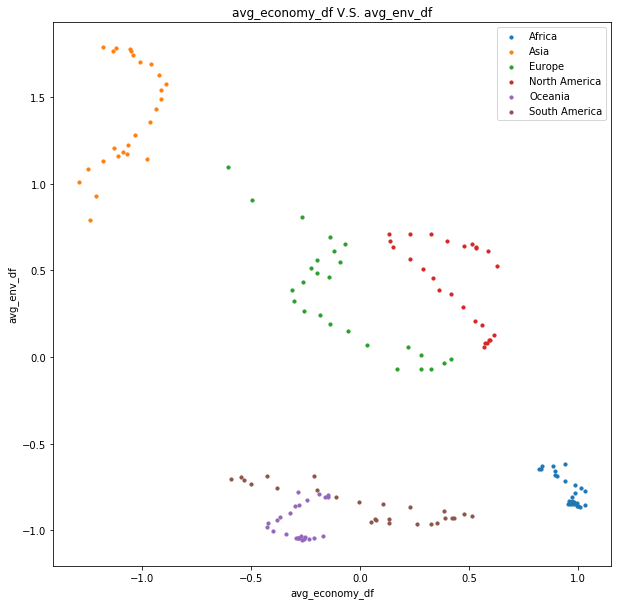

In [61]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

for c in continent:
    plt.scatter(avg_economy_df.loc[c], avg_env_df.loc[c], s=10, label=c)

plt.legend(loc='upper right')
plt.gca().update(dict(title='avg_economy_df V.S. avg_env_df', xlabel='avg_economy_df', ylabel='avg_env_df'))
plt.show()
fig.savefig('avg_economy_df V.S. avg_env_df.png', transparent=True)

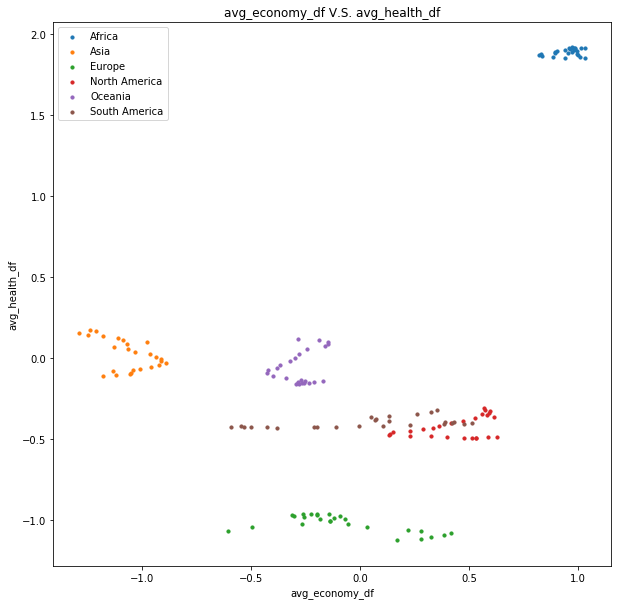

In [62]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

for c in continent:
    plt.scatter(avg_economy_df.loc[c], avg_health_df.loc[c], s=10, label=c)

plt.legend(loc='upper left')
plt.gca().update(dict(title='avg_economy_df V.S. avg_health_df', xlabel='avg_economy_df', ylabel='avg_health_df'))
plt.show()
fig.savefig('avg_economy_df V.S. avg_health_df.png', transparent=True)

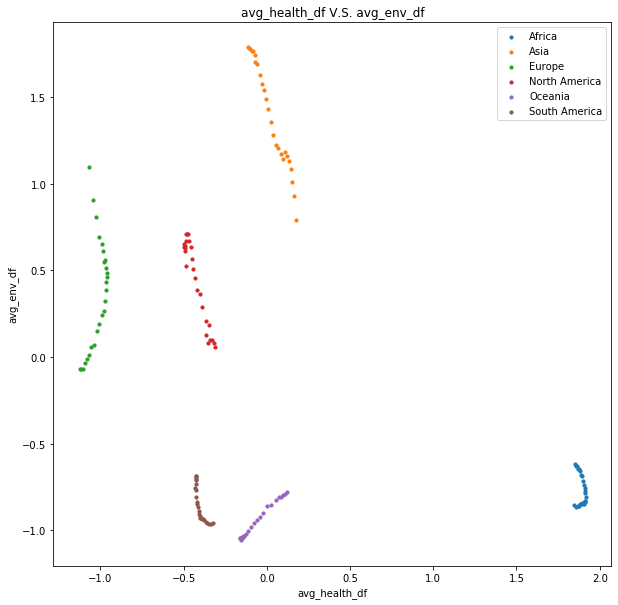

In [63]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

for c in continent:
    plt.scatter(avg_health_df.loc[c], avg_env_df.loc[c], s=10, label=c)

plt.legend(loc='upper right')
plt.gca().update(dict(title='avg_health_df V.S. avg_env_df', xlabel='avg_health_df', ylabel='avg_env_df'))
plt.show()
fig.savefig('avg_health_df V.S. avg_env_df.png', transparent=True)